This notebook compares model outputs using a range of statistical plots. The generate_report_data.ipynb notebook needs to be run before this will work.

In [1]:
import dotenv
from dotenv import load_dotenv
load_dotenv()
import os
import logging

logging.getLogger().setLevel('WARNING')
output_folder = os.environ['OUTPUT_FOLDER']

model_benchmark_cards_prefix="FwDET"
highres = os.environ['HIGHRES'] == 'TRUE'
if highres:
    dpi=600
    hextent="_high.tif"
    fig_args = {'format': "tiff", 'pil_kwargs': {"compression": "tiff_lzw"}}
else:
    dpi=300
    hextent=".png"
    fig_args = {'format':"png"}


In [2]:
import pickle
output = open(
    f'{output_folder}{os.path.sep}FwDET_model_benchmark_cards_combined.pkl', 'rb')
model_benchmark_cards_combined = pickle.load(output)
output.close()
output = open(
    f'{output_folder}{os.path.sep}FwDET_model_benchmark_cards_values.pkl', 'rb')
model_benchmark_cards_values = pickle.load(output)
output.close()


In [3]:
# from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
# gauss_model = BayesianGaussianMixture(n_components=5, random_state=42)
# gauss_model.fit(model_benchmark_cards_combined.reshape(-1, 1))
# f"Bayesian Gauss Mix":  numpy.exp(gauss_model.score_samples(numpy.reshape(combined_bin_edges, (-1, 1))))


In [4]:
from matplotlib import pyplot
import seaborn
import pandas
import scikits.bootstrap as boot
import numpy
from math import sin, pi
numpy.random.seed(42)

hists = [numpy.histogram(
    x, range=(-5, 5), bins=100, density=True)
    for x in model_benchmark_cards_values]
              
combined_hist, combined_bin_edges = numpy.histogram(
    model_benchmark_cards_combined, range=(-5, 5), bins=100)

bin_defs = list(zip(combined_bin_edges[0:len(combined_bin_edges) -
                   1], combined_bin_edges[1:]))

dis05 = []
dis25 = []
dis50 = []
dis75 = []
dis95 = []
for bin_index in range(len(combined_bin_edges)-1):
    values = [hists[x][0][bin_index] for x in range(len(model_benchmark_cards_values))]
    
    if len(values) > 1:
        av_ci = boot.ci(values, lambda x: numpy.quantile(x, 0.5),
                        alpha=[0.05, 0.25, 0.5, 0.75, 0.95], n_samples=10000)
    else:
        av_ci=[numpy.nan, numpy.nan, values[0], numpy.nan, numpy.nan]
    dis05.append(av_ci[0])
    dis25.append(av_ci[1])
    dis50.append(av_ci[2])
    dis75.append(av_ci[3])
    dis95.append(av_ci[4])

combined_ci_df = pandas.DataFrame({
    "0.05": dis05,
    "0.25": dis25,
    "0.50": dis50,
    "0.75": dis75,
    "0.95": dis95
},
    index=combined_bin_edges[1:]-(1e-03/2.0)
)
#df.loc[df["0.05"] < 0, "0.05"] = numpy.nan
#df.loc[df["0.25"] < 0, "0.25"] = numpy.nan
#df.loc[df["0.50"] < 0, "0.50"] = numpy.nan
#df.loc[df["0.75"] < 0, "0.75"] = numpy.nan
#df.loc[df["0.95"] < 0, "0.95"] = numpy.nan


In [5]:
from matplotlib import pyplot
import seaborn
import pandas
import scikits.bootstrap as boot
import numpy
from math import sin, pi

numpy.random.seed(42)
medians = [numpy.median(x) for x in model_benchmark_cards_values]
quantile_list = numpy.arange(100)/100.0
dis05 = []
dis50 = []
dis95 = []
for q in quantile_list:
    if len(medians)>1:
        av_ci = boot.ci(medians, lambda x: numpy.quantile(x, q),
                        alpha=[0.05, 0.5, 0.95], n_samples=10000)
    else:
        av_ci=[numpy.nan, medians[0], numpy.nan]
    dis05.append(av_ci[0])
    dis50.append(av_ci[1])
    dis95.append(av_ci[2])
overall_dist_df = pandas.DataFrame({
    "0.05": dis05,
    "0.50": dis50,
    "0.95": dis95
},
    index=quantile_list
)
# remove unstable numbers
#overall_dist_df.loc[overall_dist_df["0.05"] == numpy.min(medians), "0.05"] = numpy.nan
#overall_dist_df.loc[overall_dist_df["0.50"] == numpy.min(medians), "0.50"] = numpy.nan
#overall_dist_df.loc[overall_dist_df["0.95"] == numpy.min(medians), "0.95"] = numpy.nan
overall_dist_df.index.names = ['quantile']
overall_dist_df_trans = overall_dist_df.reset_index().melt(
    id_vars=['quantile'], value_vars=overall_dist_df.columns)


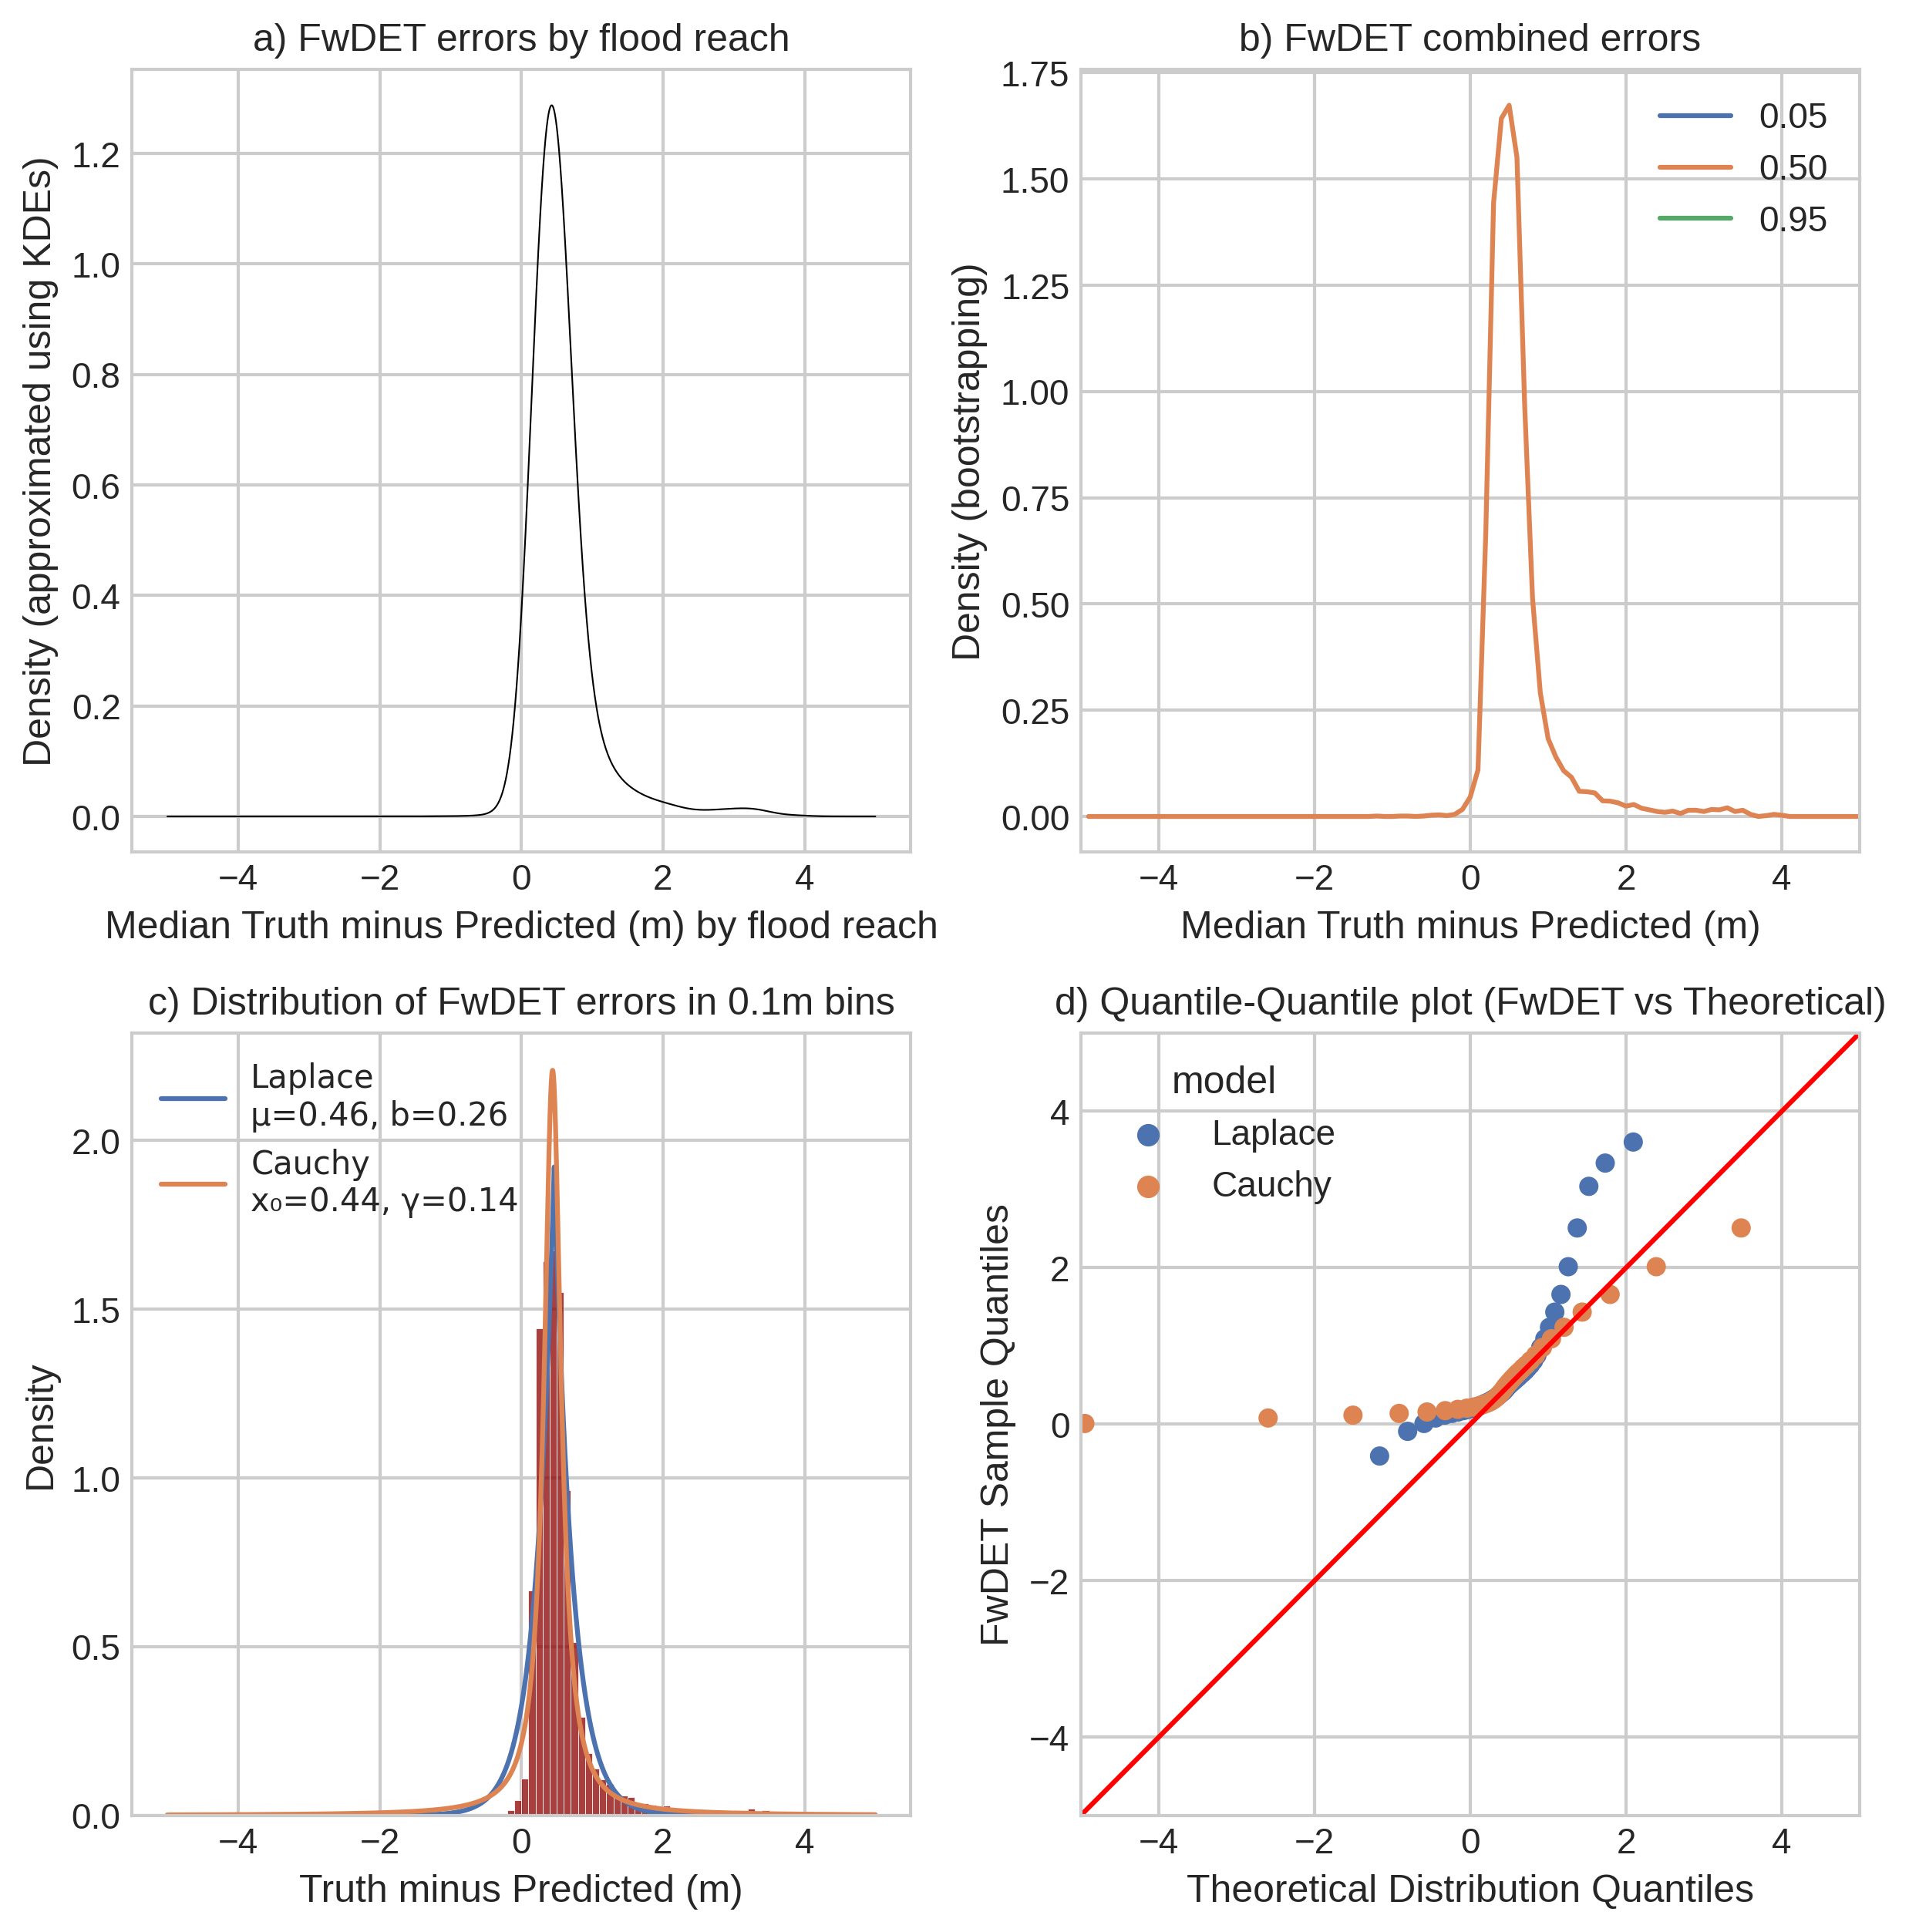

In [6]:
from sklearn.neighbors import KernelDensity
from math import sin, pi
import seaborn
from matplotlib import colors, cm, pyplot
from scipy.stats import laplace, loglaplace
import numpy
import pandas
from scipy.stats import norm, cauchy
import matplotlib.font_manager as font_manager
import matplotlib

seaborn.set(font_scale=1)
seaborn.set_theme(style="whitegrid")
pyplot.style.use('seaborn-whitegrid')
fig, axes = pyplot.subplots(
    nrows=2, ncols=2, figsize=((8.3), (11.7-1)/1.25), dpi=dpi)


combined_hist, combined_bin_edges = numpy.histogram(
    model_benchmark_cards_combined, range=(-5, 5), bins=10000)

individual_distributions = {}
for i in range(len(model_benchmark_cards_values)):
    x_vals = model_benchmark_cards_values[i].reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x_vals)
    individual_distributions[f"{i}"] = numpy.exp(
        kde.score_samples(numpy.reshape(combined_bin_edges, (-1, 1))))

individual_distributions_df = pandas.DataFrame(individual_distributions,
                                               index=combined_bin_edges
                                               )


## First plot
axis = axes[0][0]

axis.set_title("a) FwDET errors by flood reach")
seaborn.lineplot(data=individual_distributions_df, ax=axis,
                 dashes=False, linewidth=0.5, palette=['black']*len(model_benchmark_cards_values))
axis.get_legend().remove()
axis.set_xlabel("Median Truth minus Predicted (m) by flood reach")
axis.set_ylabel("Density (approximated using KDEs)")

## Second plot
axis = axes[0][1]

# seaborn.lineplot(x='value', y='quantile', hue='variable', data=overall_dist_df_trans, dashes=False, ax=axis, linewidth=0.2)

axis.set_title("b) FwDET combined errors")
seaborn.lineplot(
                 data=combined_ci_df[['0.05', '0.50', '0.95']], dashes=False, ax=axis)
axis.set_ylabel("Density (bootstrapping)")
axis.set_xlabel("Median Truth minus Predicted (m)")
axis.set_xlim(-5, 5)

## Third plot
axis = axes[1][0]

bins=100
bin_size = 10.0/bins
params = laplace.fit( model_benchmark_cards_combined)
cauchy_params = cauchy.fit(model_benchmark_cards_combined)
norm_params = norm.fit(model_benchmark_cards_combined)

res = seaborn.histplot(data=model_benchmark_cards_combined, binrange=(-5, 5),
                       ax=axis, bins=bins, stat='density', color='darkred')

axis.set_title("c) Distribution of FwDET errors in 0.1m bins")

fitted_distributions = pandas.DataFrame(
    {
        f"Laplace\n\u03bc={params[0]:.2f}, b={params[1]:.2f}":  [laplace.pdf(x, params[0], params[1])
                     for x in combined_bin_edges],
        f"Cauchy\nx\u2080={cauchy_params[0]:.2f}, \u03B3={cauchy_params[1]:.2f}":  [cauchy.pdf(x, cauchy_params[0], cauchy_params[1])
                     for x in combined_bin_edges]
        
    },
    index=combined_bin_edges
)

seaborn.lineplot(data=fitted_distributions, ax=axis,dashes=False )
font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='normal',
                                   style='normal', size=10)
axis.legend(prop=font)
axis.set_ylabel("Density")
axis.set_xlabel("Truth minus Predicted (m)")

points =50
ars = (numpy.array(range(1, points+1)) / (points+1.0)) * pi - pi/2.0
quantiles = (numpy.sin(ars)+1.0)/2.0

combined_quantiles = numpy.quantile(model_benchmark_cards_combined, quantiles)
laplace_quantiles = [laplace.ppf(x, params[0], params[1]) for x in quantiles]
cauchy_quantiles = [cauchy.ppf(x, cauchy_params[0], cauchy_params[1])
                    for x in quantiles]

l1 = pandas.DataFrame({f"x":  laplace_quantiles, },
                      index=range(len(combined_quantiles)))
l1['model'] = 'Laplace'
l1['y'] = combined_quantiles
c1 = pandas.DataFrame({f"x":  cauchy_quantiles, },
                      index=range(len(combined_quantiles)))
c1['model']='Cauchy'
c1['y']=combined_quantiles

fitted_qq = pandas.concat([l1, c1])

## Fourth plot
axis = axes[1][1]

axis.set_title("d) Quantile-Quantile plot (FwDET vs Theoretical)")

seaborn.lineplot(x=[-5, 5], y=[-5, 5], ax=axis, color='red')
seaborn.scatterplot(data=fitted_qq, x='x', y='y', hue='model', linewidth=0, ax=axis)


axis.set_xlim(-5, 5)
axis.set_ylim(-5, 5)

axis.set_ylabel("FwDET Sample Quantiles")
axis.set_xlabel("Theoretical Distribution Quantiles")

pyplot.tight_layout()
fig.subplots_adjust(top=0.95)
# pyplot.show()
pyplot.savefig(output_folder +
               f"{os.path.sep}fig_7_{model_benchmark_cards_prefix}_Overall_Histogram{hextent}", **fig_args)
#pyplot.cla()
#pyplot.clf()
#pyplot.close('all')
#pyplot.close(fig)



Text(0, 0.5, 'Median Truth minus Predicted (m)')

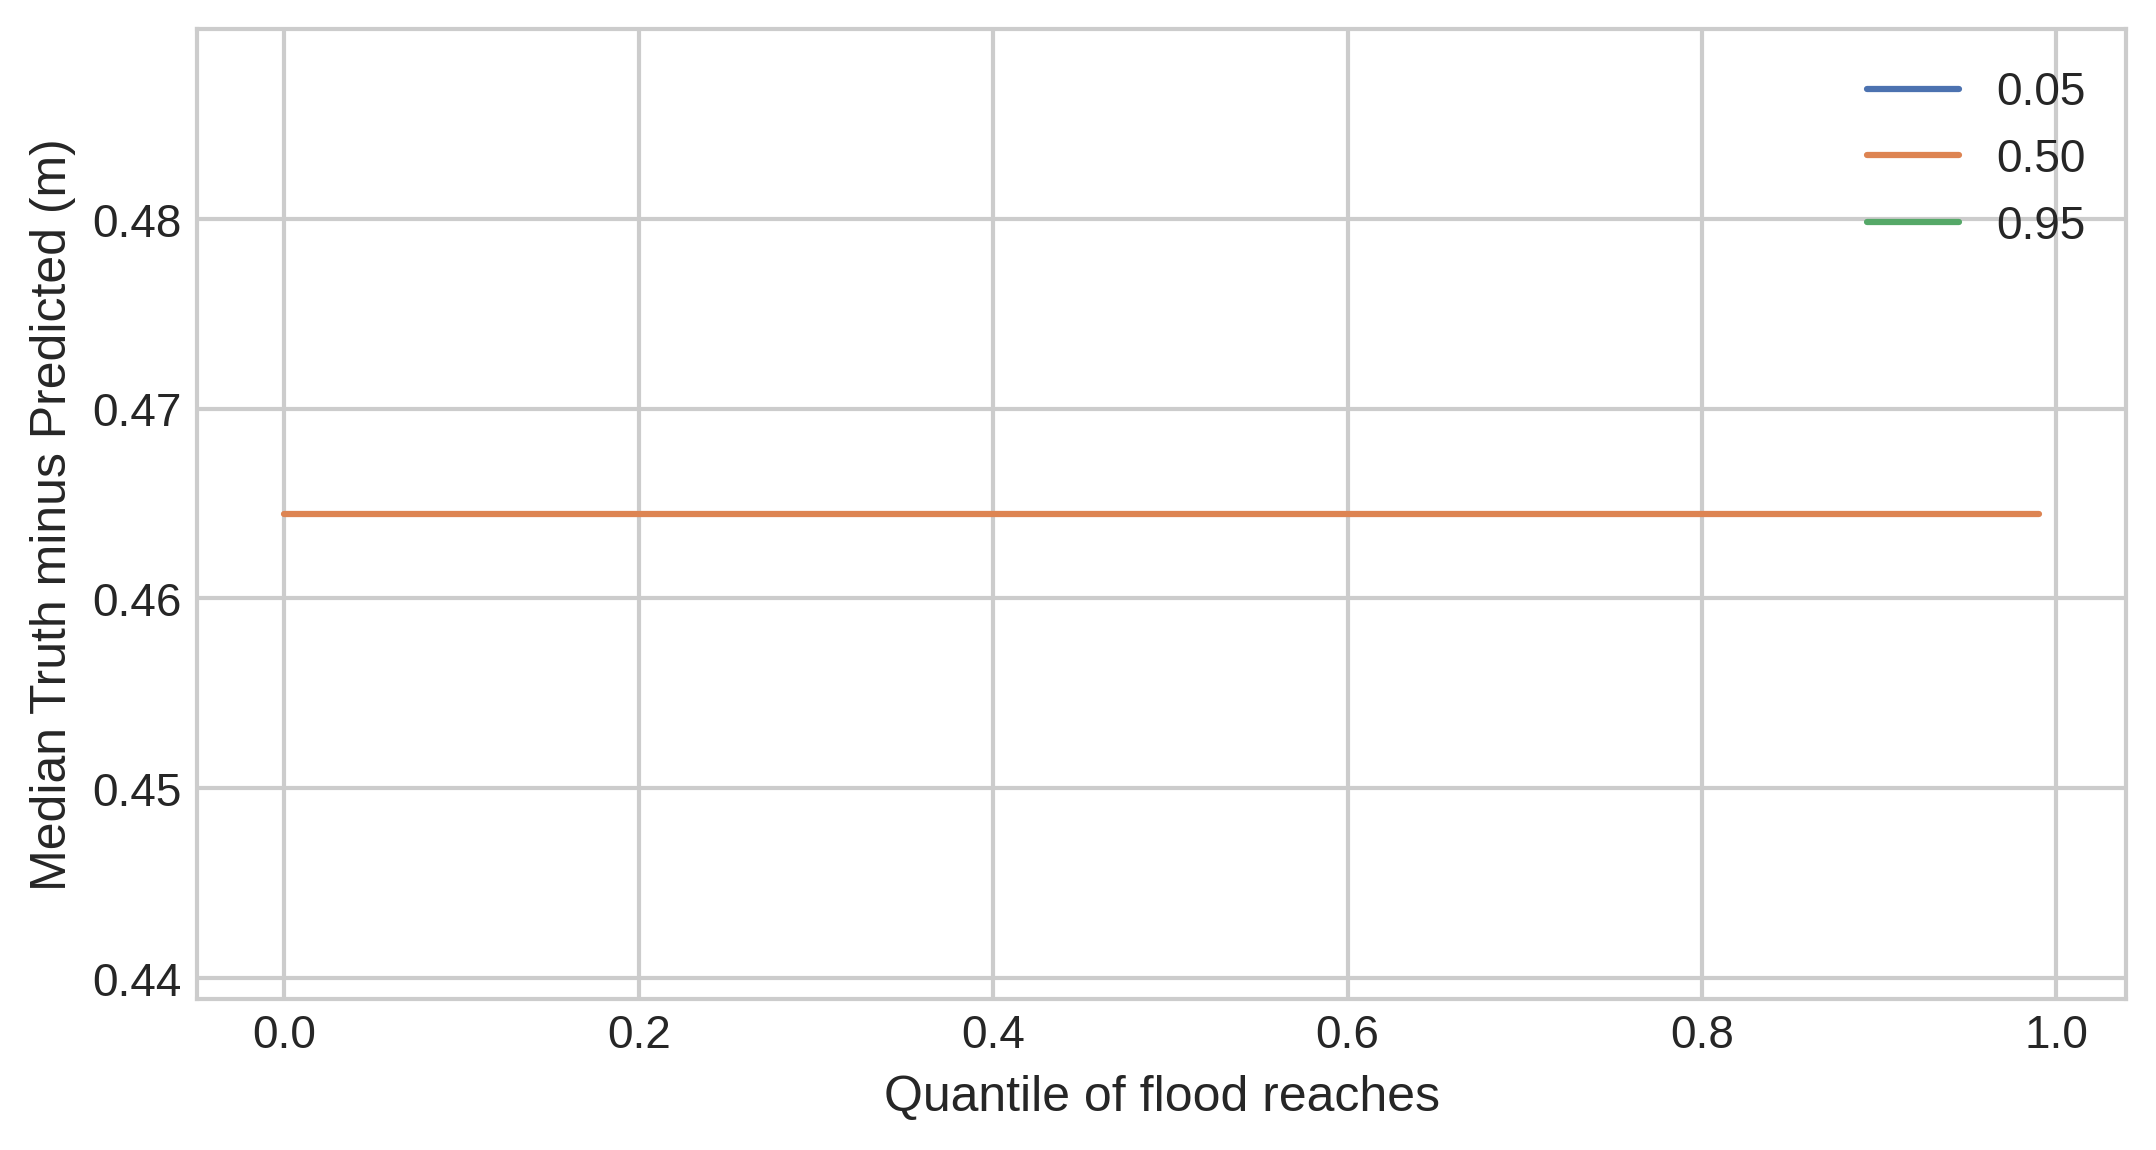

In [7]:
from matplotlib import pyplot
import seaborn
import pandas
import scikits.bootstrap as boot
import numpy
numpy.random.seed(42)
from math import sin, pi
seaborn.set(font_scale=1)
seaborn.set_theme(style="whitegrid")
pyplot.style.use('seaborn-whitegrid')
fig, axes = pyplot.subplots(
    nrows=1, ncols=1, figsize=((8.3), (11.7-1)/2.5), dpi=dpi)

medians = [numpy.median(x) for x in model_benchmark_cards_values]
quantile_list = numpy.arange(100)/100.0
dis05 = []
dis50 = []
dis95 = []
for q in quantile_list:
    if len(medians)>1:
        av_ci = boot.ci(medians, lambda x: numpy.quantile(x, q),
                        alpha=[0.05, 0.5, 0.95], n_samples=10000)
    else:
        av_ci = [numpy.nan, medians[0], numpy.nan]
    dis05.append(av_ci[0])
    dis50.append(av_ci[1])
    dis95.append(av_ci[2])
overall_dist_df = pandas.DataFrame({
    "0.05": dis05,
    "0.50": dis50,
    "0.95": dis95
},
    index=quantile_list
)
# overall_dist_df.loc[overall_dist_df["0.05"] < 0, "0.05"] = numpy.nan
# overall_dist_df.loc[overall_dist_df["0.50"] < 0, "0.50"] = numpy.nan
# overall_dist_df.loc[overall_dist_df["0.95"] < 0, "0.95"] = numpy.nan
seaborn.lineplot(data=overall_dist_df, dashes=False)
pyplot.xlabel("Quantile of flood reaches")
pyplot.ylabel("Median Truth minus Predicted (m)")


In [8]:
overall_dist_df.loc[[0.25,0.5,0.75]]


,0.05,0.50,0.95
0.25,NaN,0.464449,NaN
0.50,NaN,0.464449,NaN
0.75,NaN,0.464449,NaN


In [9]:
if len(medians)>1:
    av_ci = boot.ci(medians, lambda x: numpy.quantile(x, 0.75) - numpy.quantile(x, 0.25),
                    alpha=[0.05,0.25, 0.5, 0.75,0.95], n_samples=10000)
else:
    av_ci = medians[0]
av_ci

0.4644488

Text(0, 0.5, 'Density')

/home/pen212/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pen212/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8320 missing from current font.
  font.set_text(s, 0, flags=flags)


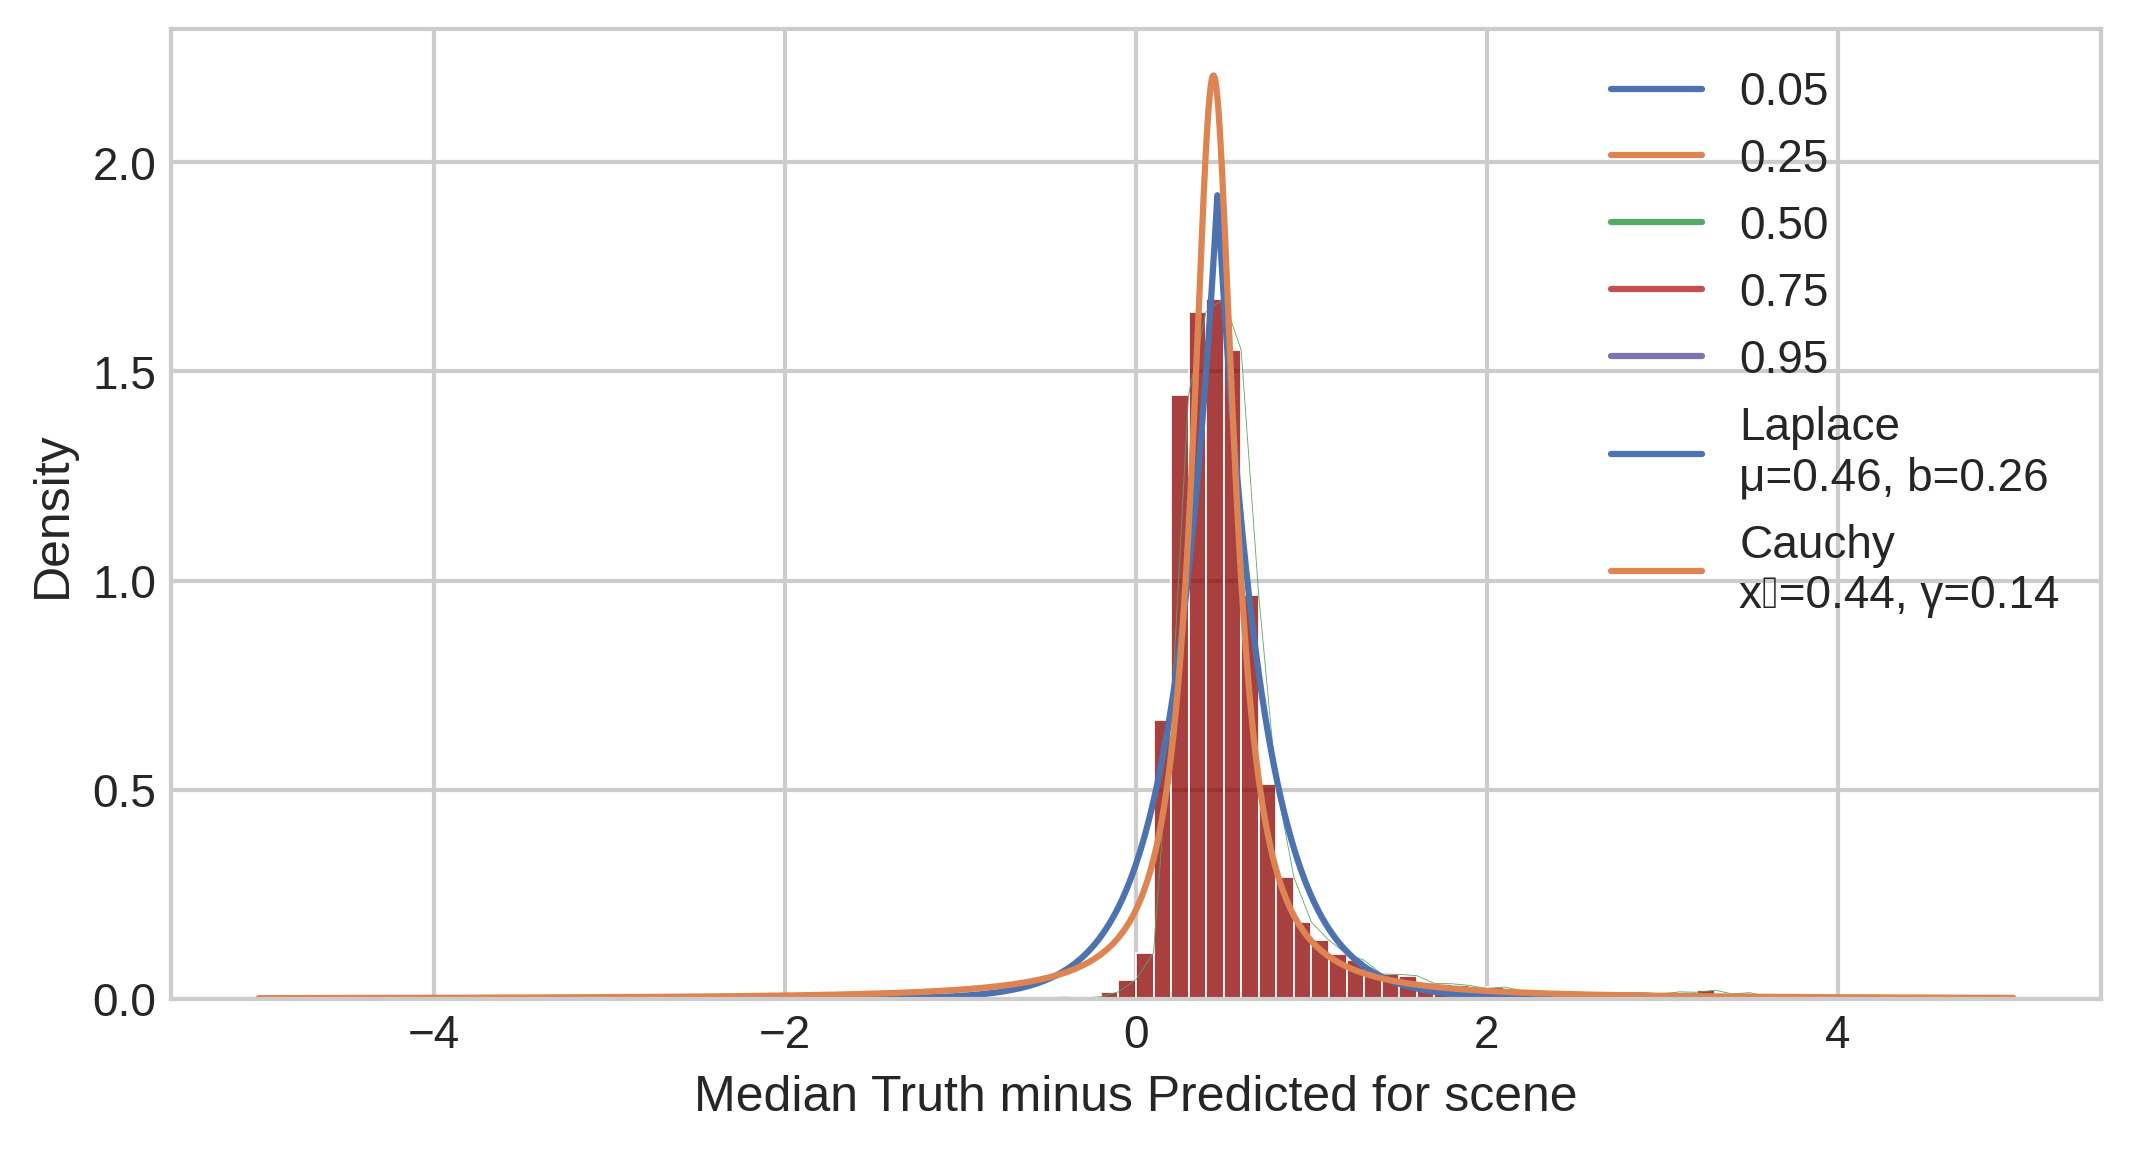

In [10]:
seaborn.set(font_scale=1)
seaborn.set_theme(style="whitegrid")
pyplot.style.use('seaborn-whitegrid')
fig, axes = pyplot.subplots(
    nrows=1, ncols=1, figsize=((8.3), (11.7-1)/2.5), dpi=dpi)

axis = axes

res = seaborn.histplot(data=model_benchmark_cards_combined, binrange=(-5, 5),
                       ax=axis, bins=bins, stat='density', color='darkred')
seaborn.lineplot(data=combined_ci_df, dashes=False, ax=axis, linewidth=0.2)
seaborn.lineplot(data=fitted_distributions, ax=axis, dashes=False)
pyplot.xlabel("Median Truth minus Predicted for scene")
pyplot.ylabel("Density")


In [11]:

fitted_qq = pandas.DataFrame(
    {
        f"laplace":  laplace_quantiles,
        f"cauchy":  cauchy_quantiles
    },
    index=combined_quantiles
)

l1 = pandas.DataFrame({f"value":  laplace_quantiles, },
                      index=combined_quantiles)
l1['model'] = 'laplace'
c1 = pandas.DataFrame({f"value":  cauchy_quantiles, },
                      index=combined_quantiles)
c1['model'] = 'cauchy'

fitted_qq=pandas.concat([l1, c1])


In [12]:
from scipy import stats
import numpy
res = stats.kstest(model_benchmark_cards_combined, 'laplace', args=params)
display((res.statistic, res.pvalue))

res = stats.kstest(model_benchmark_cards_combined, 'cauchy', args=cauchy_params)
display((res.statistic, res.pvalue))


(0.10915862124172182, 2.052776970102615e-107)

(0.1094634686045235, 5.157171785122156e-108)